# Model development
Notebook overview:
- create benchmark model
- error metrics
- create and test data loader
- train
- evaluate

In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

%matplotlib inline

In [2]:
data_dir = '../data/'

In [3]:
nasdaq_train = pd.read_csv('../data/nasdaq_export/train.csv', index_col=0, header=None)
nasdaq_test = pd.read_csv('../data/nasdaq_export/test.csv', index_col=0, header=None)

In [4]:
eurusd_train = pd.read_csv('../data/eurusd_export/train.csv', index_col=0, header=None)
eurusd_test = pd.read_csv('../data/eurusd_export/test.csv', index_col=0, header=None)

# Benchmark
Because the benchmark model is very simple and needed only in this notebook, I will define it here. Simple Moving Average forecasting implementation:

In [76]:
class MA_regressor:
    def __init__(self, N=5):
        self.N = N
    
    def forward(self, price):
        return price[-self.N:].sum() / self.N
    
    def predict(self, data, steps=10):
        predictions = np.zeros((len(data),steps))
        for i in range(0,len(data)):
            d = data[i][:,3]
            for j in range(0,steps):
                predictions[i][j] = self.forward(np.append(d, predictions[i][:j]))
        return predictions

In [77]:
sample, steps = 30, 10
benchmark = MA_regressor(15)
y = benchmark.predict([nasdaq_train.iloc[:sample].values], steps)[0]

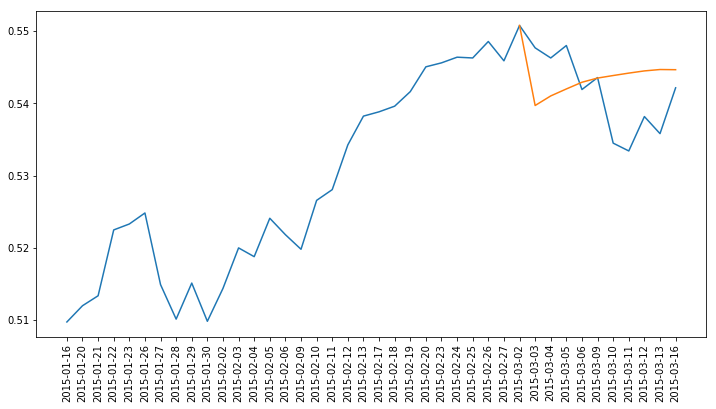

In [78]:
plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
plt.plot(nasdaq_train.iloc[:sample+steps,3])
# Reconstruct index
y_series = nasdaq_train.iloc[sample-1:sample+steps,3].copy()
y_series.iloc[1:] = y
plt.plot(y_series)

# Metrics
The sample prediction is not successfull at all, we need some metric to optimize it.

Because this is an regression problem, we need a loss function describing how far we are from the correct answer.
I propose an $MSE$ metric with a sum reduction:

\begin{equation}
MSE = \frac{1}{2} \left( y - \hat{y} \right)^2
\end{equation}

It will allow us to compute a gradient that moves towards a better solution.

In [79]:
def loss_mse(y_hat, y):
    mse = 0.0
    for a,b in zip(y_hat, y):
        mse += 0.5 * (a - b)**2
    return mse

## Optimizing our benchmark

In [80]:
target = nasdaq_train.iloc[sample:sample+steps,3].values
loss_mse(target, y)

0.00022922154932366

In [81]:
def test(in_data, target, w=1):
    loss = [[], []]
    for i in range(2, 90):
        benchmark = MA_regressor(i)
        y = benchmark.predict([in_data.values], 10)[0]
        loss[0].append(i)
        loss[1].append(loss_mse(target, y) / w)
    return np.array(loss)

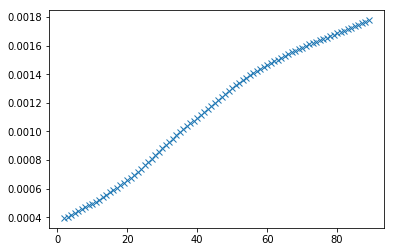

In [82]:
sample = 100
tests = 500

loss = test(nasdaq_train.iloc[:sample], nasdaq_train.iloc[sample:sample+steps,3].values, w=tests)
for offset in range(1,tests,2):
    loss[1] += test(nasdaq_train.iloc[offset:offset+sample],
                 nasdaq_train.iloc[offset+sample:offset+sample+steps,3].values, w=tests)[1]

plt.plot(*loss, 'x')

### Best benchmark model
It is clear that the lowest value of `N = 2` gives the best results over half of the NASDAQ train dataset.

Let's save it as our final benchmark.

In [83]:
benchmark = MA_regressor(N=2)

# LSTM model
Great, now that we know what the performance of our benchmark is, we can start developing a better solution.
Inside `model/model.py` I have created 2 similar LSTM Regression classes:
- LSTMRegeressor - which uses convolution to normalize the data,
- LSTMBatchRegressor - which normalizes the data with trainable 1-D Batch Normalization layer.

I will train both of them and compare the results.

## Data Loader
Before we start we need to create a data loader for our problem.
The best approach is to use a sliding window over the dataset.

In [13]:
class SlidingWindowDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        super().__init__()
        self.timeseries = data
        self.window = window_size
        self.length = len(self.timeseries)
    
    def __len__(self):
        return self.length - self.window + 1
        
    def __getitem__(self, index):
        last = index + self.window
        if index < 0 or last > self.length:
            raise IndexError
        return self.timeseries[index:last]

In [14]:
ds = SlidingWindowDataset(nasdaq_test.values, 5)
ds_loader = torch.utils.data.DataLoader(ds, batch_size=4)

In [15]:
sample = next(iter(ds_loader))
sample.shape, sample

(torch.Size([4, 5, 10]),
 tensor([[[ 7.2640e-01,  7.2433e-01,  6.9967e-01,  6.9653e-01,  1.0000e+00,
            1.0000e+00,  7.9831e-01,  8.1632e-01, -2.1493e-02,  5.0000e+01],
          [ 6.9380e-01,  6.9888e-01,  6.8697e-01,  6.8113e-01,  3.6331e-01,
            3.0000e+00,  7.9479e-01,  8.1377e-01, -1.5406e-02,  4.2857e+01],
          [ 6.9152e-01,  7.2091e-01,  6.8965e-01,  7.2088e-01,  5.6437e-01,
            2.0000e+00,  7.9257e-01,  8.1091e-01,  3.9753e-02,  3.5714e+01],
          [ 7.1354e-01,  7.2393e-01,  7.0326e-01,  7.2364e-01,  5.3282e-01,
            1.0000e+00,  7.9051e-01,  8.0862e-01,  2.7640e-03,  4.2857e+01],
          [ 7.3118e-01,  7.3506e-01,  7.2459e-01,  7.2420e-01,  4.8501e-01,
            1.0000e+00,  7.8852e-01,  8.0655e-01,  5.5320e-04,  4.2857e+01]],
 
         [[ 6.9380e-01,  6.9888e-01,  6.8697e-01,  6.8113e-01,  3.6331e-01,
            3.0000e+00,  7.9479e-01,  8.1377e-01, -1.5406e-02,  4.2857e+01],
          [ 6.9152e-01,  7.2091e-01,  6.8965e-01,  7.2

## Uploading data
We need to store our input files on S3 server.

In [16]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock_forecasting'

role = sagemaker.get_execution_role()

In [17]:
in_data = {}
for directory in ['nasdaq_export', 'eurusd_export']:
    in_data.update({directory: sagemaker_session.upload_data(path=os.path.join(data_dir,directory), bucket=bucket, key_prefix=os.path.join(prefix,directory))})
in_data

{'nasdaq_export': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/nasdaq_export',
 'eurusd_export': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/eurusd_export'}

## Training
Before we run training job let's make sure that everything works as expected.

In [18]:
import model.model as mdl
import model.train as trn

In [19]:
def get_data_loader(batch_size, sliding_window, training_dir, file='train.csv'):
    train_data = pd.read_csv(os.path.join(training_dir, file), index_col=0, header=None)
    train_ds = mdl.SlidingWindowDataset(train_data.values, sliding_window)
    return torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

In [20]:
inputs = 30
outputs = 3

model = mdl.LSTMRegressor(input_size=inputs, input_channels=10, c_filters=3, c_kernel_size=3, lstm_layers=2, lstm_hidden=4, dropout=0.2, output_size=outputs)
model = model.double()

In [21]:
loss_fn = torch.nn.MSELoss(reduction='sum')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = get_data_loader(128, inputs+outputs, os.path.join(data_dir,'nasdaq_export'))
optimizer = torch.optim.Adam(model.parameters())

In [22]:
trn.train(model, outputs, train_loader, 20, optimizer, loss_fn, device)

Epoch: 1, Loss: 0.13191596853816542
Epoch: 2, Loss: 0.12857407977602725
Epoch: 3, Loss: 0.12644020234273284
Epoch: 4, Loss: 0.123874264309348
Epoch: 5, Loss: 0.11967853351165889
Epoch: 6, Loss: 0.11569392155274813
Epoch: 7, Loss: 0.10936117161732786
Epoch: 8, Loss: 0.10245235848138327
Epoch: 9, Loss: 0.09402521965352684
Epoch: 10, Loss: 0.08704493995592558
Epoch: 11, Loss: 0.08072698736573619
Epoch: 12, Loss: 0.0761617211787556
Epoch: 13, Loss: 0.07360198868657394
Epoch: 14, Loss: 0.07176944780479594
Epoch: 15, Loss: 0.07078124102348358
Epoch: 16, Loss: 0.06775783487640374
Epoch: 17, Loss: 0.06475976677126434
Epoch: 18, Loss: 0.06468439176376856
Epoch: 19, Loss: 0.062184910524602066
Epoch: 20, Loss: 0.060499823883047456


## Perform Training
Here we will train a model with 9 channels on EURUSD dataset, then on NASDAQ (with Volume dropped) and finally we will evaluate its performance.

Hyperparameters were set manually with some experimentation. Feel free to adjust them yourself.

In [23]:
from sagemaker.pytorch import PyTorch

In [24]:
estimator = PyTorch(entry_point="train.py",
                    source_dir="model",
                    role=role,
                    framework_version='1.2.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 20,
                        'batch-size': 256,
                        'input-size': 30,
                        'input-channels': 9,
                        'c-filters': 4,
                        'lstm-hidden': 10,
                        'lstm-layers': 3,
                        'output-size': 10,
                    })

In [25]:
estimator.fit({'training': in_data['eurusd_export']})

2020-01-29 17:01:21 Starting - Starting the training job...
2020-01-29 17:01:23 Starting - Launching requested ML instances......
2020-01-29 17:02:28 Starting - Preparing the instances for training......
2020-01-29 17:03:48 Downloading - Downloading input data......
2020-01-29 17:04:40 Training - Downloading the training image............
2020-01-29 17:06:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-29 17:06:54,253 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-29 17:06:54,279 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-29 17:06:54,280 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-29 17:06:54,571 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-01-29 17:06:54

### Model S3 Location
For our web application deployment we will use S3 location of our estimator:

**Copy result of the cell below - it is required in the next notebook!**

In [26]:
estimator.model_data

's3://sagemaker-us-east-1-236375122127/pytorch-training-2020-01-29-17-01-21-129/output/model.tar.gz'

## Evaluating
Here we deploy our estimator, test how does it perform on both NASDAQ and EURUSD. After everything runs without errors, we will compare the result against our benchmark.

In [27]:
predictor = estimator.deploy(instance_type='ml.p2.xlarge', initial_instance_count=1)

---------------------------------------------------------------------------------------------------------------------------------------!

In [29]:
ds_eurusd = SlidingWindowDataset(eurusd_test.values, 30)
predictor.predict(np.array([ds_eurusd[0], ds_eurusd[1]]))

array([[0.90480262, 0.90481553, 0.90481897, 0.90482936, 0.90482484,
        0.90481337, 0.90482297, 0.9048293 , 0.90484982, 0.90487079],
       [0.90510768, 0.90514474, 0.90517785, 0.90520461, 0.90521909,
        0.90523099, 0.90526374, 0.90527884, 0.90531298, 0.90533821]])

In [30]:
nasdaq9 = [0,1,2,3,5,6,7,8,9]
nasdaq_test.iloc[:,nasdaq9].head()

,1,2,3,4,6,7,8,9,10
0,,,,,,,,,
2018-12-21,0.726395,0.724334,0.699668,0.696531,1.0,0.798306,0.816316,-0.021493,50.000000
2018-12-24,0.693796,0.698876,0.686965,0.681125,3.0,0.794791,0.813769,-0.015406,42.857143
2018-12-26,0.691517,0.720908,0.689648,0.720878,2.0,0.792573,0.810908,0.039753,35.714286
2018-12-27,0.713543,0.723930,0.703257,0.723642,1.0,0.790505,0.808621,0.002764,42.857143
2018-12-28,0.731180,0.735056,0.724592,0.724195,1.0,0.788516,0.806553,0.000553,42.857143


In [31]:
ds_nasdaq = SlidingWindowDataset(nasdaq_test.iloc[:,nasdaq9].values, 30)
predictor.predict(np.array([ds_nasdaq[0], ds_nasdaq[1]]))

array([[0.80893191, 0.80945195, 0.80995133, 0.8105491 , 0.80922292,
        0.80793295, 0.80868434, 0.80872074, 0.80921673, 0.81001494],
       [0.83240737, 0.83358723, 0.83477446, 0.83621585, 0.83573888,
        0.83522236, 0.83655151, 0.83700724, 0.83769249, 0.83921076]])

## Benchmark vs LSTM Solution

In [64]:
test_in = np.array([ds_nasdaq[0], ds_eurusd[0]])
test_y = np.array([np.append(test_in[0,:,3],ds_nasdaq[30][:10,3]),
                   np.append(test_in[1,:,3],ds_eurusd[30][:10,3])])

In [85]:
ma_y = benchmark.predict(test_in, 10)

In [66]:
model_y = predictor.predict(test_in)

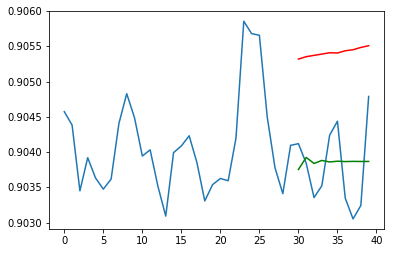

In [86]:
x = np.arange(len(test_y[1]))
plt.plot(x, test_y[1])
plt.plot(x[-10:], ma_y[1], 'g')
plt.plot(x[-10:], model_y[1], 'r')

## Clean-up
We will not need this endpoint anymore, so let's remove it.

In [68]:
estimator.delete_endpoint()

# Summary
Model is ready to deploy. Final deployment steps will be performed in the `WebApp.ipynb` notebook.